# Imports and Loading NLP Model

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1, rc={
    'figure.figsize': (15, 10),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#333333',
    'xtick.color': '#666666',
    'ytick.color': '#666666'
})

import spacy
from spacy import displacy

import networkx as nx
from pyvis.network import Network
import community as community_louvain

import os

import re

import requests
from bs4 import BeautifulSoup

from tqdm import tqdm

In [3]:
NER = spacy.load("en_core_web_sm")

In [4]:
books = [book for book in os.scandir('data')]
books

[<DirEntry '1 The Last Wish.txt'>,
 <DirEntry '2 Sword of Destiny.txt'>,
 <DirEntry '3 Blood of Elves.txt'>,
 <DirEntry '4 Time of Contempt.txt'>,
 <DirEntry '5 Baptism of Fire.txt'>,
 <DirEntry '6 The Tower of the Swallow.txt'>,
 <DirEntry '7 The Lady of the Lake.txt'>,
 <DirEntry '8 Something Ends, Something Begins.txt'>]

In [5]:
book_text = open(books[0]).read()
book_doc = NER(book_text)

In [6]:
displacy.render(book_doc[0:500], style='ent', jupyter=True)

# Getting Character Names

In [7]:
def book_to_url(book):
    book = book.name.split('.')[0][2:].replace(' ', '_')
    return f'https://witcher.fandom.com/wiki/Category:{book}_characters'

In [8]:
# URL of the webpage to scrape
urls = [book_to_url(book) for book in books]
characters_df = pd.DataFrame(columns=['Book', 'Character', 'First Name'])

for idx, url in enumerate(urls):

    # Send a GET request to the URL
    response = requests.get(url)

    # Parse the HTML content of the page using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find the list of character names and titles on the page
    tags_list = soup.find_all('div', {'class': 'category-page__member-left'})

    book_characters = []

    # Define a regular expression pattern to match brackets and their contents
    pattern = r'\[[^\]]*\]|\([^\)]*\)'


    # Print out the names and titles of the characters
    for character in tags_list:
        try:
            name = character.find('a')['title']
            # Use the sub method to replace matches with an empty string and then remove trailing whitespaces
            name = re.sub(pattern, '', name).rstrip()
            book_characters.append(name)
        except:
            continue

    book_name = books[idx].name.split('.')[0][2:]
    _characters_df = pd.DataFrame({'Book': book_name,'Character': book_characters})
    _characters_df['First Name'] = _characters_df['Character'].apply(lambda x: x.split(' ')[0])
    characters_df = characters_df.append(_characters_df, ignore_index=True)

In [9]:
characters_df

,Book,Character,First Name
0,The Last Wish,Adda of Temeria,Adda
1,The Last Wish,Adda the White,Adda
2,The Last Wish,Aen Saevherne,Aen
3,The Last Wish,Arthur Tailles,Arthur
4,The Last Wish,Audoen,Audoen
...,...,...,...
593,"Something Ends, Something Begins",Vesemir,Vesemir
594,"Something Ends, Something Begins",Villentretenmerth,Villentretenmerth
595,"Something Ends, Something Begins",Visenna,Visenna
596,"Something Ends, Something Begins",Yarpen Zigrin,Yarpen


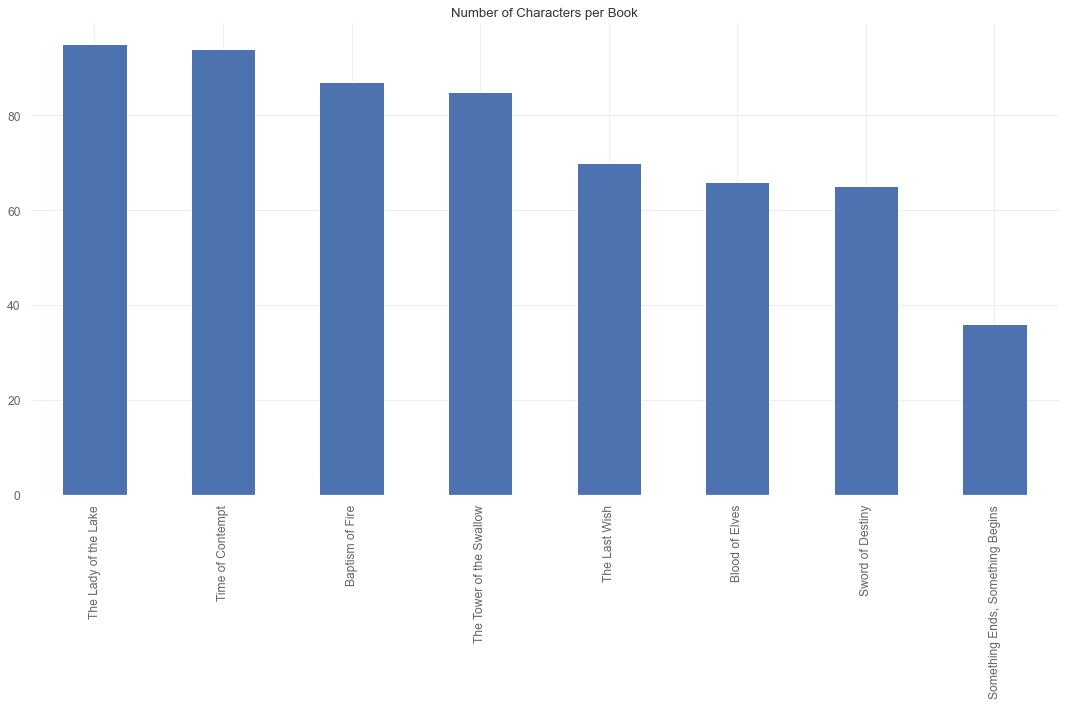

In [10]:
characters_df['Book'].value_counts().plot(kind='bar')
plt.title('Number of Characters per Book')
plt.tight_layout()
plt.show()

In [11]:
sent_entity_df = []
for sent in tqdm(book_doc.sents):
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)
sent_entity_df

10119it [00:57, 176.89it/s]


,sentence,entities
0,"(﻿'Does, she, always, devour, her, victims, ?,...",[]
1,"(Velerad, spat, vehemently, on, the, straw, .,...",[Velerad]
2,('),[]
3,"(Come, on, ,, Geralt, ,, it, 'll, be, supper, ...",[]
4,"(Pish, !)",[]
...,...,...
10114,"(', I, 've, got, to, .)",[]
10115,"(See, to, Iola, .)",[]
10116,"(So, long, ,, Nenneke, ., ')",[Nenneke]
10117,"(The, priestess, slowly, shook, her, head, ,, ...",[]


In [12]:
def filter_entity(ent_list, characters_df):
    return [ent for ent in ent_list
            if ent in list(characters_df['Character']) 
            or ent in list(characters_df['First Name'])]
filter_entity(["Geralt of Rivia", "Geralt", "2"], characters_df)

['Geralt of Rivia', 'Geralt']

In [13]:
sent_entity_df['filtered entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, characters_df))
sent_entity_df['filtered entities'] = sent_entity_df['filtered entities'].apply(lambda x: [item.split()[0] for item in x])
sent_entity_df_filtered = sent_entity_df[sent_entity_df['filtered entities'].map(len) > 0]

In [14]:
sent_entity_df_filtered

,sentence,entities,filtered entities
1,"(Velerad, spat, vehemently, on, the, straw, .,...",[Velerad],[Velerad]
7,"(Damned, mother's-, !, ', \n\n, ', Careful, ,,...",[Ostrit],[Ostrit]
8,"(Say, what, you, want, about, the, striga, but...",[Adda],[Adda]
12,"(Segelin, and, Ostrit, looked, at, each, other...",[Ostrit],[Ostrit]
17,"(And, then, ,, ', interrupted, Velerad, ,, ')",[Velerad],[Velerad]
...,...,...,...
10082,"(Nenneke, shouted, ., ')",[Nenneke],[Nenneke]
10088,"(Nenneke, ,, growing, red, with, the, effort, ...",[Nenneke],[Nenneke]
10091,"(Nenneke, raised, herself, to, her, knees, and...",[Nenneke],[Nenneke]
10103,"(', Do, n't, say, anything, ,, Nenneke, ., ', ...",[Nenneke],[Nenneke]


In [15]:
def create_edges_table(characters):
    edges = []

    for char_list in characters:
        for i in range(1, len(char_list)-1):
            source = char_list[i]
            target_before = char_list[i-1]
            target_after = char_list[i+1]
            edges.append((source, target_before))
            edges.append((source, target_after))

        if len(char_list) > 1:
            # If the current sublist has more than one character, create an edge between the first and second characters
            edges.append((char_list[1], char_list[0]))
            # Create an edge between the last and second-to-last characters
            edges.append((char_list[-2], char_list[-1]))

    return edges

In [16]:
edges_df = pd.DataFrame(create_edges_table(list(sent_entity_df_filtered['filtered entities'])), columns=['Source', 'Target'])
edges_df

,Source,Target
0,Geralt,Ostrit
1,Ostrit,Geralt
2,Segelin,Velerad
3,Velerad,Segelin
4,Nenneke,Geralt
...,...,...
125,Falwick,Geralt
126,Falwick,Geralt
127,Geralt,Falwick
128,Geralt,Dennis


In [17]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i]['filtered entities']), [])
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [18]:
relationships_df = pd.DataFrame(relationships)
relationships_df["value"] = 1
relationship_df = relationships_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [19]:
relationship_df

,source,target,value
0,Ostrit,Adda,5
1,Adda,Ostrit,2
2,Ostrit,Velerad,1
3,Foltest,Adda,3
4,Ostrit,Geralt,13
...,...,...,...
199,Dennis,Falwick,1
200,Falwick,Dennis,7
201,Geralt,Dennis,4
202,Dennis,Geralt,9


In [20]:
# Create a graph from a pandas dataframe
G = nx.from_pandas_edgelist(relationship_df, 
                            source = "source", 
                            target = "target", 
                            edge_attr = "value", 
                            create_using = nx.Graph())

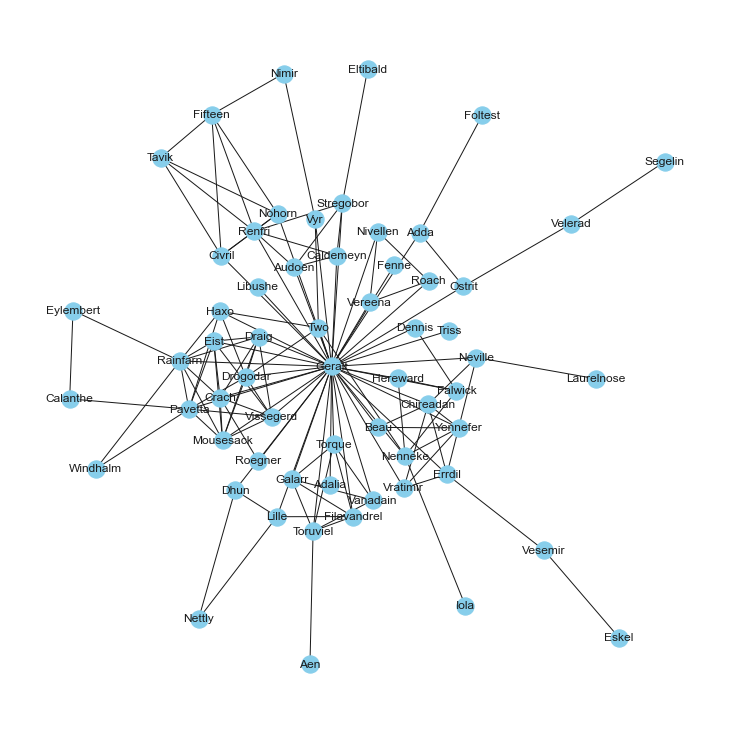

In [21]:
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [22]:
communities = community_louvain.best_partition(G)

In [23]:
communities

{'Ostrit': 0,
 'Adda': 0,
 'Velerad': 0,
 'Foltest': 0,
 'Geralt': 2,
 'Segelin': 0,
 'Nenneke': 2,
 'Roach': 2,
 'Two': 2,
 'Nivellen': 2,
 'Fenne': 2,
 'Vereena': 2,
 'Hereward': 2,
 'Falwick': 2,
 'Caldemeyn': 5,
 'Stregobor': 5,
 'Eltibald': 5,
 'Vyr': 2,
 'Nimir': 2,
 'Fifteen': 5,
 'Nohorn': 5,
 'Renfri': 5,
 'Civril': 5,
 'Tavik': 5,
 'Audoen': 5,
 'Libushe': 2,
 'Haxo': 1,
 'Drogodar': 1,
 'Rainfarn': 1,
 'Eylembert': 1,
 'Calanthe': 1,
 'Pavetta': 1,
 'Eist': 1,
 'Crach': 1,
 'Mousesack': 1,
 'Draig': 1,
 'Vissegerd': 1,
 'Roegner': 2,
 'Windhalm': 1,
 'Adalia': 2,
 'Nettly': 3,
 'Dhun': 3,
 'Lille': 3,
 'Torque': 3,
 'Galarr': 3,
 'Vanadain': 3,
 'Toruviel': 3,
 'Filavandrel': 3,
 'Aen': 3,
 'Yennefer': 4,
 'Iola': 2,
 'Errdil': 4,
 'Vratimir': 4,
 'Chireadan': 4,
 'Beau': 4,
 'Triss': 2,
 'Neville': 4,
 'Laurelnose': 4,
 'Eskel': 4,
 'Vesemir': 4,
 'Dennis': 2}

In [24]:
net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')

node_degree = dict(G.degree)

#Setting up node size attribute
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("witcher.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [25]:
nx.set_node_attributes(G, communities, 'group')

In [26]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white')
com_net.from_nx(G)
com_net.show("witcher_communities.html")

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
